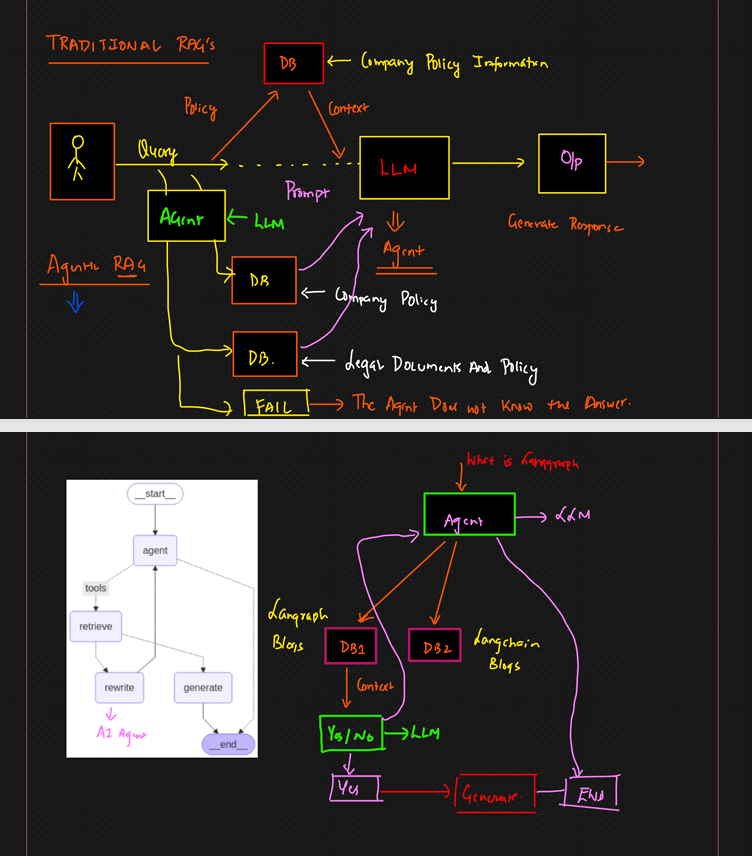

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='<think>\nOkay, the user said "Hello". I should respond in a friendly and welcoming way. Let me make sure to keep it simple and open-ended so they feel comfortable to ask anything. Maybe add an emoji to keep it approachable. Alright, something like "Hello! How can I assist you today? 😊" Yeah, that sounds good.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 9, 'total_tokens': 95, 'completion_time': 0.164275975, 'prompt_time': 0.004643382, 'queue_time': 0.050432778, 'total_time': 0.168919357}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e00e5b02-99ef-4f86-85f4-4ed7ef6a31f7-0', usage_metadata={'input_tokens': 9, 'output_tokens': 86, 'total_tokens': 95})

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from bs4 import BeautifulSoup
# 2. Load and Clean Web Pages
# ========================
langgraph_urls = [
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs = []
for url in langgraph_urls:
    loader = WebBaseLoader(url)
    raw_docs = loader.load()
    for doc in raw_docs:
        # Clean HTML with BeautifulSoup
        soup = BeautifulSoup(doc.page_content, "html.parser")
        clean_text = soup.get_text(separator=" ", strip=True)
        doc.page_content = clean_text
        docs.append(doc)

In [4]:
# 3. Split Text into Chunks
# ========================
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs_list = [item for item in docs]  # Flatten if needed
doc_splits = text_splitter.split_documents(docs_list)

print(f"Number of document chunks: {len(doc_splits)}")

Number of document chunks: 47


In [5]:
# 4. Embed and Save to FAISS
# Load your API key from the .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv("Google_API_KEY")
# ========================
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)
vectorstore = FAISS.from_documents(doc_splits, embeddings)
vectorstore.save_local("langgraph_faiss_index")

In [6]:
retriever= vectorstore.as_retriever()

In [7]:
retriever.invoke("What is LangGraph?")


[Document(id='e1916786-54f7-4726-8513-5e8a4fd8e57a', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='LangSmith Trace\nhttps://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r\nWhat LangGraph provides¶\nBy constructing each of the above in LangGraph, we get a few things:\nPersistence: Human-in-the-Loop¶\nLangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See Module 3 of LangChain Academy.\nPersistence: Memory¶\nLangGraph persistence layer supports conversational (short-term) memory and long-term memory. See Modules 2 and 5 of LangChain Academy:\nStreaming¶\nLangGraph provides several ways to stream workflow / agent outputs or intermediate state. See Module 3 of LangChain Academy.\nDeployment¶\nLangGraph provides an easy on-ramp for deployment

In [8]:
# SOLUTION 1A: Use langchain-core tools (if updated properly)
try:
    from langchain_core.tools import create_retriever_tool
    retriever_tool_langgraph = create_retriever_tool(
        retriever=retriever,
        name="LangGraphRetriever",
        description="A tool to retrieve LangGraph documentation and tutorials."
    )
    print("✅ Using langchain-core create_retriever_tool")
except Exception as e:
    print(f"❌ langchain-core method failed: {e}")
    # Fall back to alternative solution

✅ Using langchain-core create_retriever_tool


In [9]:
import langchain
import pydantic
import langchain_core
print("LangChain:", langchain.__version__)
print("Pydantic:", pydantic.__version__)
print("LangChain Core:", langchain_core.__version__)


LangChain: 0.3.26
Pydantic: 2.11.7
LangChain Core: 0.3.69


## Langchain URL

In [10]:
# 2. Load and Clean Web Pages (CORRECTED)
# ========================
langchain_urls = [
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs = []
for url in langchain_urls:  # FIXED: Use langchain_urls instead of urls
    try:
        loader = WebBaseLoader(url)
        raw_docs = loader.load()
        for doc in raw_docs:
            # Clean HTML with BeautifulSoup
            soup = BeautifulSoup(doc.page_content, "html.parser")
            clean_text = soup.get_text(separator=" ", strip=True)
            doc.page_content = clean_text
            docs.append(doc)
        print(f"✅ Loaded {len(raw_docs)} documents from {url}")
    except Exception as e:
        print(f"❌ Failed to load {url}: {e}")

print(f"Total documents loaded: {len(docs)}")

✅ Loaded 1 documents from https://python.langchain.com/docs/tutorials/
✅ Loaded 1 documents from https://python.langchain.com/docs/tutorials/chatbot/
✅ Loaded 1 documents from https://python.langchain.com/docs/tutorials/qa_chat_history/
Total documents loaded: 3


In [11]:
# 3. Split Text into Chunks
# ========================
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs_list = [item for item in docs]  # Flatten if needed
doc_splits = text_splitter.split_documents(docs_list)

print(f"Number of document chunks: {len(doc_splits)}")


Number of document chunks: 100


In [12]:
# 4. Embed and Save to FAISS
# Load your API key from the .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv("Google_API_KEY")
# ========================
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)
vectorstore = FAISS.from_documents(doc_splits, embeddings)
vectorstore.save_local("langchain_faiss_index")
retriever= vectorstore.as_retriever()


    # Fall back to alternative solution

In [13]:
retriever.invoke("What is langchain?")

[Document(id='d91c45c2-0c5f-4bbc-a2a1-994fa5b99a2e', metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Tutorials | 🦜️🔗 LangChain', 'description': 'New to LangChain or LLM app development in general? Read this material to quickly get up and running building your first applications.', 'language': 'en'}, page_content='outputsTestingString-in, string-out llmsText splittersTokensTool callingToolsTracingVector storesWhy LangChain?Ecosystem🦜🛠️ LangSmith🦜🕸️ LangGraphVersionsv0.3v0.2Pydantic compatibilityMigrating from v0.0 chainsHow to migrate from v0.0 chainsMigrating from ConstitutionalChainMigrating from ConversationalChainMigrating from ConversationalRetrievalChainMigrating from LLMChainMigrating from LLMMathChainMigrating from LLMRouterChainMigrating from MapReduceDocumentsChainMigrating from MapRerankDocumentsChainMigrating from MultiPromptChainMigrating from RefineDocumentsChainMigrating from RetrievalQAMigrating from StuffDocumentsChainUpgrading to LangGraph

In [14]:
# SOLUTION 1A: Use langchain-core tools (if updated properly)
try:
    from langchain_core.tools import create_retriever_tool
    retriever_tool_langchain = create_retriever_tool(
        retriever=retriever,
        name="LangChainRetriever",
        description="A tool to retrieve LangChain documentation and tutorials."
    )
    print("✅ Using langchain-core create_retriever_tool")
except Exception as e:
    print(f"❌ langchain-core method failed: {e}")

✅ Using langchain-core create_retriever_tool


In [15]:
tools=[retriever_tool_langgraph, retriever_tool_langchain]

### LangGraph Workflow

In [16]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class state(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [17]:
llm.invoke("hello")

AIMessage(content='<think>\nOkay, the user said "hello". That\'s a common greeting. I should respond in a friendly and welcoming manner. Maybe ask how I can assist them. Keep it simple and open-ended. Let them know I\'m here to help with whatever they need.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 9, 'total_tokens': 77, 'completion_time': 0.127966653, 'prompt_time': 0.000208577, 'queue_time': 0.051305233, 'total_time': 0.12817523}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--aa9ef187-69b7-4848-b1d6-a6b6d4550aee-0', usage_metadata={'input_tokens': 9, 'output_tokens': 68, 'total_tokens': 77})

In [18]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen/qwen3-32b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [19]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="qwen/qwen3-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [20]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen/qwen3-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [21]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen/qwen3-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

In [22]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(state)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool_langgraph, retriever_tool_langchain])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()



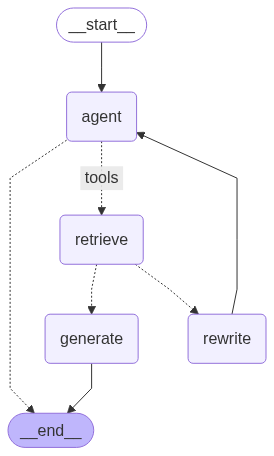

In [23]:
graph

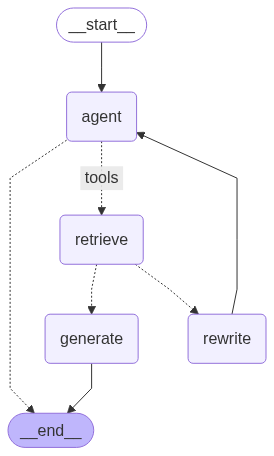

In [24]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='993d25ea-ebd3-4b42-ba5b-0c234e792c4e'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is Langgraph?" I need to figure out which tool to use here. There are two retrievers available: LangGraphRetriever and LangChainRetriever. Since the user specifically mentioned "Langgraph," I should use the LangGraphRetriever to get the most relevant information. The query parameter should be the question itself. Let me structure the tool call with the query as "What is Langgraph?" to retrieve the necessary details.\n', 'tool_calls': [{'id': 'x622nar2h', 'function': {'arguments': '{"query":"What is Langgraph?"}', 'name': 'LangGraphRetriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 215, 'total_tokens': 345, 'completion_time': 0.216700189, 'prompt_time': 0.008333588, 'queue_time': 0.05112

In [26]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='a9359b4a-91a7-4e13-8b07-33ad8539ee30'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is Langchain?" I need to figure out which tool to use here. There are two retrievers available: LangGraphRetriever and LangChainRetriever. The question is about Langchain, so the LangChainRetriever seems more appropriate. The parameters require a query, which in this case would be "What is Langchain?" I should structure the tool call with that query. Let me make sure I\'m using the correct function name and parameters. Yes, the LangChainRetriever takes a query parameter. So the tool call should be the LangChainRetriever with the query "What is Langchain?".\n', 'tool_calls': [{'id': 'h53ssxm1d', 'function': {'arguments': '{"query":"What is Langchain?"}', 'name': 'LangChainRetriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'comple

In [27]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='0672ece5-ea58-43ce-9be0-2b7776e3525c'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is Machine learning?" I need to figure out which tool to use here. There are two retrievers available: LangGraphRetriever and LangChainRetriever. Both have the same parameters, just a query string.\n\nFirst, I should check if there\'s any documentation or context that suggests which retriever is more appropriate for this query. Since the question is pretty general, maybe either would work. However, sometimes LangChain is more commonly used for general knowledge retrieval, while LangGraph might be for graph-based data. But without specific info, it\'s hard to tell.\n\nWait, maybe the user has access to both, but I need to pick one. Since the query is straightforward, perhaps using LangChainRetriever first would be better as it\'s a more stand